In [1]:
import pickle as pkl
import numpy as np
import seaborn as sns
%matplotlib inline

sns.set(context="poster", style='whitegrid', font='sans-serif')

X_real = pkl.load(open('./data/X_processed.pkl', 'rb'))
y_real = pkl.load(open('./data/y_processed.pkl', 'rb'))

print(X_real.shape, y_real.shape)

output_dir = './output/'
public_dir = output_dir + 'acgan_500_0.0002_100'

# private directory for multiple epoch testing - p7
private_dir = output_dir + 'p7_8.0_0.0001_500_0.002_100'

((6502, 3, 12), (6502,))


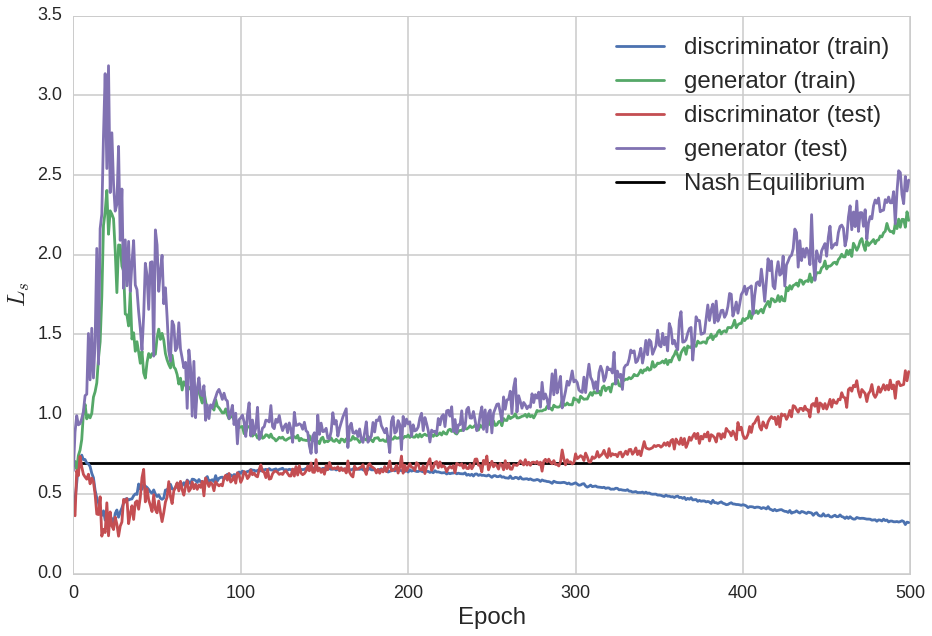

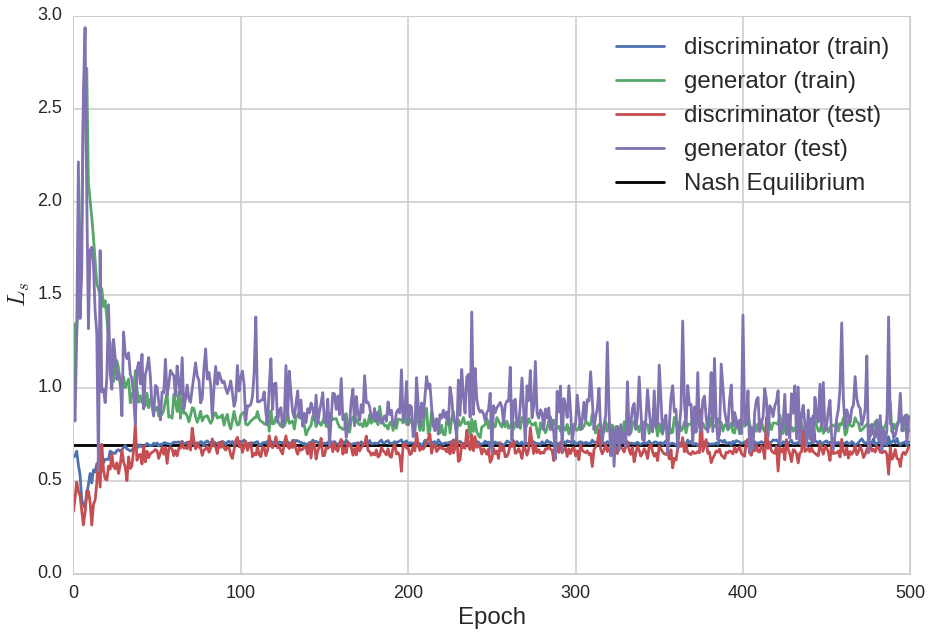

In [2]:
import h5py
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline
plt.figure(figsize=(15,10))

hist = pkl.load(open(public_dir + '/acgan-history.pkl', 'rb'))
losses = ['loss', 'generation_loss', 'auxiliary_loss']

for p in ['train', 'test']:
    for g in ['discriminator', 'generator']:
        hist[p][g] = pd.DataFrame(hist[p][g], columns=losses)

for p in ['train', 'test']:
    for g in ['discriminator', 'generator']:
        plt.plot(hist[p][g]['generation_loss'], label='{} ({})'.format(g, p))

# get the NE and show as an equilibrium point
plt.hlines(-np.log(0.5), 0, hist[p][g]['generation_loss'].shape[0], label='Nash Equilibrium')
plt.legend(fontsize=24)
plt.xlabel('Epoch', fontsize=24)
plt.ylabel(r'$L_s$',  fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.show()


plt.figure(figsize=(15,10))
hist = pkl.load(open(private_dir + '/acgan-history.pkl', 'rb'))
losses = ['loss', 'generation_loss', 'auxiliary_loss']

for p in ['train', 'test']:
    for g in ['discriminator', 'generator']:
        hist[p][g] = pd.DataFrame(hist[p][g], columns=losses)

for p in ['train', 'test']:
    for g in ['discriminator', 'generator']:
        plt.plot(hist[p][g]['generation_loss'], label='{} ({})'.format(g, p))

# get the NE and show as an equilibrium point
plt.hlines(-np.log(0.5), 0, hist[p][g]['generation_loss'].shape[0], label='Nash Equilibrium')
plt.legend(fontsize=24)
plt.xlabel('Epoch', fontsize=24)
plt.ylabel(r'$L_s$', fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.show()

3.67315048103e-05
0.00349799195485


(array([   5.,   16.,   36.,  119.,  206.,   67.,   35.,   11.,    4.,    1.]),
 array([-0.01167002, -0.00898496, -0.00629989, -0.00361483, -0.00092977,
         0.0017553 ,  0.00444036,  0.00712543,  0.00981049,  0.01249555,
         0.01518062]),
 <a list of 10 Patch objects>)

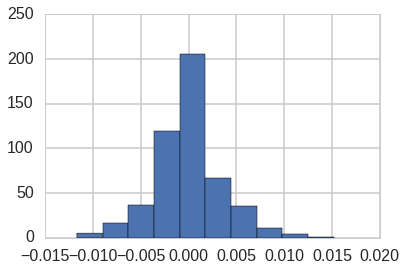

In [3]:
noise = np.random.laplace(loc=0.0, scale=0.25, size=500) / 100
print(np.mean(noise))
print(np.std(noise))
plt.hist(noise)

In [4]:
public_scores = pkl.load(open(public_dir + '/epoch_scores.p', 'rb'))
top_10_public = np.argsort(public_scores['rf'])[-5:]
top_10_lr = np.argsort(public_scores['lr'])[-5:]
top_10_public = np.concatenate([top_10_public, top_10_lr])
print(top_10_public)

[406 439 374 488 378 477 421 432 474 497]


In [16]:
np.random.seed(501)
# noisy selection
epoch_scores = pkl.load(open(private_dir + '/epoch_scores.p', 'rb'))

eps_per = 0.05
size = 500

top_5_rf = []
top_5_lr = []

for i in range(5):
    print(eps_per*size)
    noisy_epoch_scores_rf = (epoch_scores['rf'] + 
                             (np.random.laplace(loc=0.0,
                                                scale=(1/(eps_per*size)),
                                                size=500)))
    
    j=1
    while(np.argsort(noisy_epoch_scores_rf)[-j:][0] in top_5_rf):
        j += 1
    top_5_rf.append(np.argsort(noisy_epoch_scores_rf)[-j:][0])
    size = size - 1
    
    noisy_epoch_scores_lr = (epoch_scores['lr'] + 
                             (np.random.laplace(loc=0.0,
                                                scale=(1/(eps_per*size)),
                                                size=500) / 100))
    k=1
    while(np.argsort(noisy_epoch_scores_lr)[-k:][0] in top_5_lr):
        k += 1
    top_5_lr.append(np.argsort(noisy_epoch_scores_lr)[-k:][0])
    size = size - 1


rf_noisy_scores = [epoch_scores['rf'][x] for x in top_5_rf]
lr_noisy_scores = [epoch_scores['lr'][x] for x in top_5_lr]
top_10 = np.concatenate([top_5_rf, top_5_lr])
print('top 10 ', top_10)
print(rf_noisy_scores, lr_noisy_scores)


rf_clean_scores = [epoch_scores['rf'][x] for x in np.argsort(epoch_scores['rf'])[-5:]]
lr_clean_scores = [epoch_scores['lr'][x] for x in np.argsort(epoch_scores['lr'])[-5:]]
print(rf_clean_scores, lr_clean_scores)

25.0
24.9
24.8
24.7
24.6
('top 10 ', array([149, 304, 159, 158, 303,  91,  67,  60,  92, 145]))
([0.83864541832669326, 0.87051792828685259, 0.87250996015936255, 0.83067729083665343, 0.87848605577689243], [0.74302788844621515, 0.73705179282868527, 0.73505976095617531, 0.72908366533864544, 0.72509960159362552])
([0.88247011952191234, 0.88247011952191234, 0.8844621513944223, 0.88844621513944222, 0.89043824701195218], [0.72509960159362552, 0.72908366533864544, 0.73505976095617531, 0.73705179282868527, 0.74302788844621515])


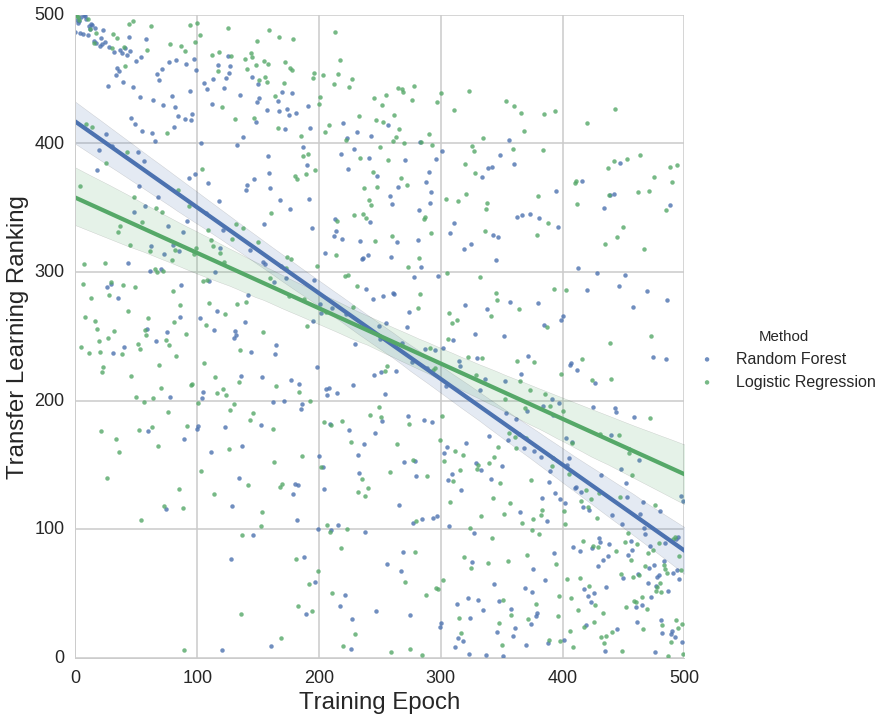

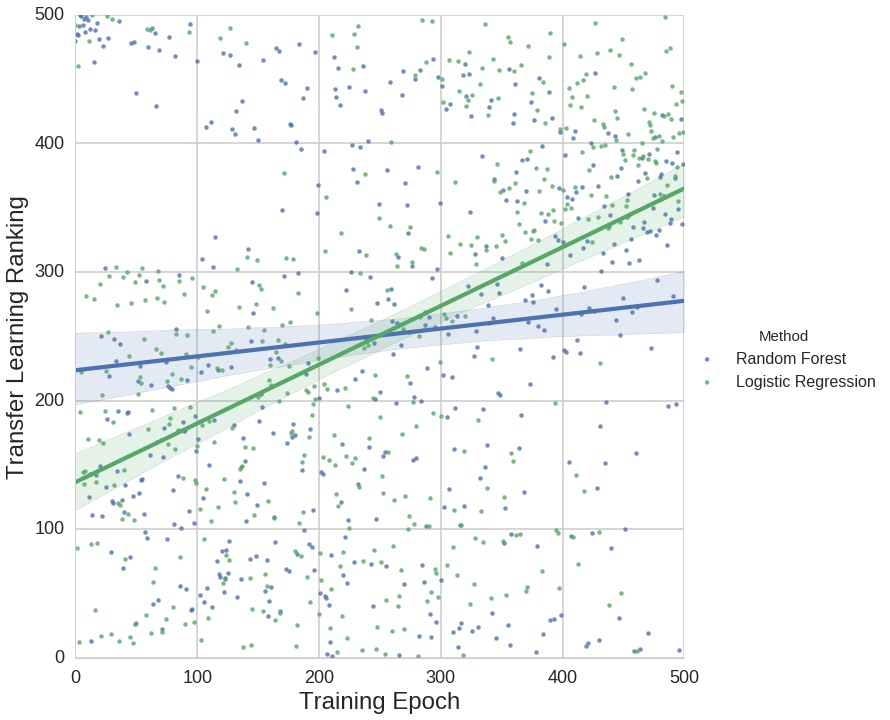

In [17]:
# plot public
public = np.concatenate([500-np.argsort(public_scores['rf']), 500-np.argsort(public_scores['lr'])])
index = np.concatenate([range(500), range(500)])
method = np.concatenate([['Random Forest'] * 500, ['Logistic Regression'] * 500])

arg_scores = {'rank':public, 'index':index, 'Method':method}
arg_scores_df = pd.DataFrame.from_dict(arg_scores)

plt.figure(figsize=(15,10))
g = sns.lmplot(x="index", y="rank", hue="Method", data=arg_scores_df, size=10,
               y_jitter=.02, logistic=False, legend=True, legend_out=True)
g.set(xlim=(0, 500), ylim=(0, 500))

plt.xlabel('Training Epoch', fontsize=24)
plt.ylabel('Transfer Learning Ranking', fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=18)

public = np.concatenate([500-np.argsort(epoch_scores['rf']), 500-np.argsort(epoch_scores['lr'])])
index = np.concatenate([range(500), range(500)])
method = np.concatenate([['Random Forest'] * 500, ['Logistic Regression'] * 500])

arg_scores = {'rank':public, 'index':index, 'Method':method}
arg_scores_df = pd.DataFrame.from_dict(arg_scores)

plt.figure(figsize=(15,10))
g = sns.lmplot(x="index", y="rank", hue="Method", data=arg_scores_df, size=10,
               y_jitter=.02, logistic=False, legend=True, legend_out=True)
g.set(xlim=(0, 500), ylim=(0, 500))

plt.xlabel('Training Epoch', fontsize=24)
plt.ylabel('Transfer Learning Ranking', fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=18)

In [18]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

from keras.models import load_model

acgan = __import__('ac_gan')

generate_count = 5000
latent_size = 100

X_private = []
y_private = []

X_public = []
y_public = []

for i in range(len(top_10)):
    print(i)
    private_gen = load_model(private_dir + '/params_generator_epoch_' + "{0:0=3d}".format(top_10[i]) + '.h5')
    public_gen = load_model(public_dir + '/params_generator_epoch_' + "{0:0=3d}".format(top_10_public[i]) + '.h5')
    
    noise = np.random.uniform(-1, 1, (generate_count, latent_size))
    sampled_labels = np.random.randint(0, 2, generate_count)
    
    X_public.extend(public_gen.predict([noise, sampled_labels.reshape((-1, 1))], verbose=0))
    y_public.extend(sampled_labels)

    X_private.extend(private_gen.predict([noise, sampled_labels.reshape((-1, 1))], verbose=0))
    y_private.extend(sampled_labels)

X_private = np.array(X_private)
y_private = np.array(y_private)

X_public = np.array(X_public)
y_public = np.array(y_public)
print(X_private.shape, y_private.shape, X_public.shape, y_public.shape)

X_public = X_public.reshape(X_public.shape[0], X_public.shape[2], X_public.shape[3]).clip(min=0).astype('int')
X_private = X_private.reshape(X_private.shape[0], X_private.shape[2], X_private.shape[3]).clip(min=0).astype('int')
print(X_private.shape)

0
1
2
3
4
5
6
7
8
9
((50000, 1, 3, 12), (50000,), (50000, 1, 3, 12), (50000,))
(50000, 3, 12)


In [19]:
epochs = 500 - 1

last_priv_gen = load_model(private_dir + '/params_generator_epoch_' + str(epochs) + '.h5')
last_public_gen = load_model(public_dir + '/params_generator_epoch_' + str(epochs) + '.h5')
noise = np.random.uniform(-1, 1, (generate_count, latent_size))
sampled_labels = np.random.randint(0, 2, generate_count)

last_X_private = last_priv_gen.predict([noise, sampled_labels.reshape((-1, 1))], verbose=0)
last_X_public = last_public_gen.predict([noise, sampled_labels.reshape((-1, 1))], verbose=0)

last_y_private = sampled_labels
last_y_public = sampled_labels

last_X_public = last_X_public.reshape(last_X_public.shape[0],
                                      last_X_public.shape[2],
                                      last_X_public.shape[3]).clip(min=0).astype('int')
last_X_private = last_X_private.reshape(last_X_private.shape[0],
                                        last_X_private.shape[2], 
                                        last_X_private.shape[3]).clip(min=0).astype('int')

In [20]:
real_split = 6000
X_train = X_real[:real_split]
X_test = X_real[real_split:]

y_train = y_real[:real_split]
y_test = y_real[real_split:]

print(X_private.shape)
print(X_real.shape)

stats_dict = {}
stats_dict['overall_mean_sp'] = [np.mean(X_train[:, 0, :]), np.mean(X_public[:, 0, :]), np.mean(X_private[:, 0, :])]
stats_dict['overall_mean_dp'] = [np.mean(X_train[:, 1, :]), np.mean(X_public[:, 1, :]), np.mean(X_private[:, 1, :])]
stats_dict['overall_mean_meds'] = [np.mean(X_train[:, 2, :]), np.mean(X_public[:, 2, :]), np.mean(X_private[:, 2, :])]

print(stats_dict)

(50000, 3, 12)
(6502, 36)


IndexError: too many indices for array

In [ ]:
from numpy import median 
import matplotlib.patches as mpatches

standard_real = X_real[y_real==0] 
intensive_real = X_real[y_real==1]

standard_public = X_public[y_public==0] 
intensive_public = X_public[y_public==1]

standard_private = X_private[y_private==0] 
intensive_private = X_private[y_private==1]

print(standard_real[:3])
print(standard_real.shape, intensive_real.shape)
print(standard_public.shape, intensive_public.shape)
print(standard_private.shape, intensive_private.shape)

standard_real_sbp = standard_real[:, 0, :]
intensive_real_sbp = intensive_real[:, 0, :]

standard_public_sbp = standard_public[:, 0, :]
intensive_public_sbp =  intensive_public[:, 0, :]

standard_private_sbp = standard_private[:, 0, :]
intensive_private_sbp = intensive_private[:, 0, :]

colors = ['#B21E0D', '#FF412B', '#0E5FCC', '#537CB2', '#9300B2', '#DA2BFF']
visit_codes = ['RZ', '1M', '2M', '3M', '6M', '9M', '12M', '15M',
               '18M', '21M', '24M', '27M']

plt.figure(figsize=(20, 20))
ax = sns.pointplot(data=standard_real_sbp, estimator=median, color=colors[0], label='Real Standard')
ax = sns.pointplot(data=intensive_real_sbp, estimator=median, color=colors[1], label='Real Intensive')

ax = sns.pointplot(data=standard_public_sbp, estimator=median, color=colors[2], label='Non-Private Standard')
ax = sns.pointplot(data=intensive_public_sbp, estimator=median, color=colors[3], label='Non-Private Intensive')

ax = sns.pointplot(data=standard_private_sbp, estimator=median, color=colors[4], label='Private Standard')
ax = sns.pointplot(data=intensive_private_sbp, estimator=median, color=colors[5], label='Private Intensive')

real_standard_patch = mpatches.Patch(color=colors[0], label='Real Standard')
real_intensive_patch = mpatches.Patch(color=colors[1], label='Real Intensive')
public_standard_patch = mpatches.Patch(color=colors[2], label='Non-Private Standard')
public_intensive_patch = mpatches.Patch(color=colors[3], label='Non-Private Intensive')
private_standard_patch = mpatches.Patch(color=colors[4], label='Private Standard')
private_intensive_patch = mpatches.Patch(color=colors[5], label='Private Intensive')

ax.legend(handles=[real_standard_patch, real_intensive_patch, public_standard_patch, public_intensive_patch,
                   private_standard_patch, private_intensive_patch],
          fontsize=20)
ax.set_ylim([100, 170])
ax.set_xticklabels(visit_codes)
plt.tick_params(axis='both', which='major', labelsize=28)
plt.title('Multi-epoch Model (top 5 RF, top 5 LR)', fontsize=36)
plt.xlabel('Visit', fontsize=32)
plt.ylabel('Systolic Blood Pressure', fontsize=32)
plt.show()

# only top epoch rf
standard_public = X_public[:generate_count][y_public[:generate_count]==0] 
intensive_public = X_public[:generate_count][y_public[:generate_count]==1]

standard_private = X_private[:generate_count][y_private[:generate_count]==0] 
intensive_private = X_private[:generate_count][y_private[:generate_count]==1]

standard_real_sbp = standard_real[:generate_count, 0, :]
intensive_real_sbp = intensive_real[:generate_count, 0, :]

standard_public_sbp = standard_public[:generate_count, 0, :]
intensive_public_sbp =  intensive_public[:generate_count, 0, :]

standard_private_sbp = standard_private[:generate_count, 0, :]
intensive_private_sbp = intensive_private[:generate_count, 0, :]

print(sns.cubehelix_palette(n_colors=2, start=0))
colors = ['#B21E0D', '#FF412B', '#0E5FCC', '#537CB2', '#9300B2', '#DA2BFF']
visit_codes = ['RZ', '1M', '2M', '3M', '6M', '9M', '12M', '15M',
               '18M', '21M', '24M', '27M']

plt.figure(figsize=(20, 20))
ax = sns.pointplot(data=standard_real_sbp, estimator=median, color=colors[0], label='Real Standard')
ax = sns.pointplot(data=intensive_real_sbp, estimator=median, color=colors[1], label='Real Intensive')

ax = sns.pointplot(data=standard_public_sbp, estimator=median, color=colors[2], label='Non-Private Standard')
ax = sns.pointplot(data=intensive_public_sbp, estimator=median, color=colors[3], label='Non-Private Intensive')

ax = sns.pointplot(data=standard_private_sbp, estimator=median, color=colors[4], label='Private Standard')
ax = sns.pointplot(data=intensive_private_sbp, estimator=median, color=colors[5], label='Private Intensive')

real_standard_patch = mpatches.Patch(color=colors[0], label='Real Standard')
real_intensive_patch = mpatches.Patch(color=colors[1], label='Real Intensive')
public_standard_patch = mpatches.Patch(color=colors[2], label='Non-Private Standard')
public_intensive_patch = mpatches.Patch(color=colors[3], label='Non-Private Intensive')
private_standard_patch = mpatches.Patch(color=colors[4], label='Private Standard')
private_intensive_patch = mpatches.Patch(color=colors[5], label='Private Intensive')

ax.legend(handles=[real_standard_patch, real_intensive_patch, public_standard_patch, public_intensive_patch,
                   private_standard_patch, private_intensive_patch],
          fontsize=20)
ax.set_ylim([100, 170])
ax.set_xticklabels(visit_codes)
plt.tick_params(axis='both', which='major', labelsize=28)
plt.title('Top Random Forest Model', fontsize=36)
plt.xlabel('Visit', fontsize=32)
plt.ylabel('Systolic Blood Pressure', fontsize=32)
plt.show()

# only top feature lr
standard_real_sbp = standard_real[:, 0, :]
intensive_real_sbp = intensive_real[:, 0, :]

standard_public = X_public[(generate_count*5):(generate_count*6)][y_public[(generate_count*5):(generate_count*6)]==0] 
intensive_public = X_public[(generate_count*5):(generate_count*6)][y_public[(generate_count*5):(generate_count*6)]==1]

standard_private = X_private[(generate_count*5):(generate_count*6)][y_private[(generate_count*5):(generate_count*6)]==0] 
intensive_private = X_private[(generate_count*5):(generate_count*6)][y_private[(generate_count*5):(generate_count*6)]==1]

standard_public_sbp = standard_public[:generate_count, 0, :]
intensive_public_sbp =  intensive_public[:generate_count, 0, :]
print('Public ', standard_public_sbp.shape, intensive_public_sbp.shape)

standard_private_sbp = standard_private[:generate_count, 0, :]
intensive_private_sbp = intensive_private[:generate_count, 0, :]
print('Private ', standard_private_sbp.shape, intensive_private_sbp.shape)

print(sns.cubehelix_palette(n_colors=2, start=0))
colors = ['#B21E0D', '#FF412B', '#0E5FCC', '#537CB2', '#9300B2', '#DA2BFF']
visit_codes = ['RZ', '1M', '2M', '3M', '6M', '9M', '12M', '15M',
               '18M', '21M', '24M', '27M']

plt.figure(figsize=(20, 20))
ax = sns.pointplot(data=standard_real_sbp, estimator=median, color=colors[0], label='Real Standard')
ax = sns.pointplot(data=intensive_real_sbp, estimator=median, color=colors[1], label='Real Intensive')

ax = sns.pointplot(data=standard_public_sbp, estimator=median, color=colors[2], label='Non-Private Standard')
ax = sns.pointplot(data=intensive_public_sbp, estimator=median, color=colors[3], label='Non-Private Intensive')

ax = sns.pointplot(data=standard_private_sbp, estimator=median, color=colors[4], label='Private Standard')
ax = sns.pointplot(data=intensive_private_sbp, estimator=median, color=colors[5], label='Private Intensive')

real_standard_patch = mpatches.Patch(color=colors[0], label='Real Standard')
real_intensive_patch = mpatches.Patch(color=colors[1], label='Real Intensive')
public_standard_patch = mpatches.Patch(color=colors[2], label='Non-Private Standard')
public_intensive_patch = mpatches.Patch(color=colors[3], label='Non-Private Intensive')
private_standard_patch = mpatches.Patch(color=colors[4], label='Private Standard')
private_intensive_patch = mpatches.Patch(color=colors[5], label='Private Intensive')

ax.legend(handles=[real_standard_patch, real_intensive_patch, public_standard_patch, public_intensive_patch,
                   private_standard_patch, private_intensive_patch],
          fontsize=20)
ax.set_ylim([100, 170])
ax.set_xticklabels(visit_codes)
plt.tick_params(axis='both', which='major', labelsize=28)
plt.title('Top Logistic Regression Model', fontsize=36)
plt.xlabel('Visit', fontsize=32)
plt.ylabel('Systolic Blood Pressure', fontsize=32)
plt.show()

# only last epoch
standard_real = X_real[y_real==0] 
intensive_real = X_real[y_real==1]

standard_public = last_X_public[last_y_public==0] 
intensive_public = last_X_public[last_y_public==1]

standard_private = last_X_private[last_y_private==0] 
intensive_private = last_X_private[last_y_private==1]

standard_real_sbp = standard_real[:, 0, :]
intensive_real_sbp = intensive_real[:, 0, :]

standard_public_sbp = standard_public[:generate_count, 0, :]
intensive_public_sbp =  intensive_public[:generate_count, 0, :]

standard_private_sbp = standard_private[:generate_count, 0, :]
intensive_private_sbp = intensive_private[:generate_count, 0, :]

print(sns.cubehelix_palette(n_colors=2, start=0))
colors = ['#B21E0D', '#FF412B', '#0E5FCC', '#537CB2', '#9300B2', '#DA2BFF']
visit_codes = ['RZ', '1M', '2M', '3M', '6M', '9M', '12M', '15M',
               '18M', '21M', '24M', '27M']

plt.figure(figsize=(20, 20))
ax = sns.pointplot(data=standard_real_sbp, estimator=median, color=colors[0], label='Real Standard')
ax = sns.pointplot(data=intensive_real_sbp, estimator=median, color=colors[1], label='Real Intensive')

ax = sns.pointplot(data=standard_public_sbp, estimator=median, color=colors[2], label='Non-Private Standard')
ax = sns.pointplot(data=intensive_public_sbp, estimator=median, color=colors[3], label='Non-Private Intensive')

ax = sns.pointplot(data=standard_private_sbp, estimator=median, color=colors[4], label='Private Standard')
ax = sns.pointplot(data=intensive_private_sbp, estimator=median, color=colors[5], label='Private Intensive')

real_standard_patch = mpatches.Patch(color=colors[0], label='Real Standard')
real_intensive_patch = mpatches.Patch(color=colors[1], label='Real Intensive')
public_standard_patch = mpatches.Patch(color=colors[2], label='Non-Private Standard')
public_intensive_patch = mpatches.Patch(color=colors[3], label='Non-Private Intensive')
private_standard_patch = mpatches.Patch(color=colors[4], label='Private Standard')
private_intensive_patch = mpatches.Patch(color=colors[5], label='Private Intensive')

ax.legend(handles=[real_standard_patch, real_intensive_patch, public_standard_patch, public_intensive_patch,
                   private_standard_patch, private_intensive_patch],
          fontsize=20)
ax.set_ylim([100, 170])
ax.set_xticklabels(visit_codes)
plt.tick_params(axis='both', which='major', labelsize=28)
plt.title('Final Epoch (500) Model', fontsize=36)
plt.xlabel('Visit', fontsize=32)
plt.ylabel('Systolic Blood Pressure', fontsize=32)
plt.show()

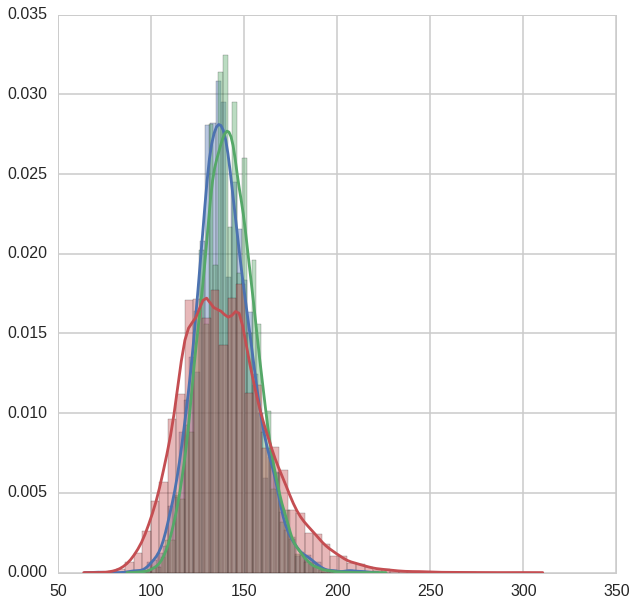

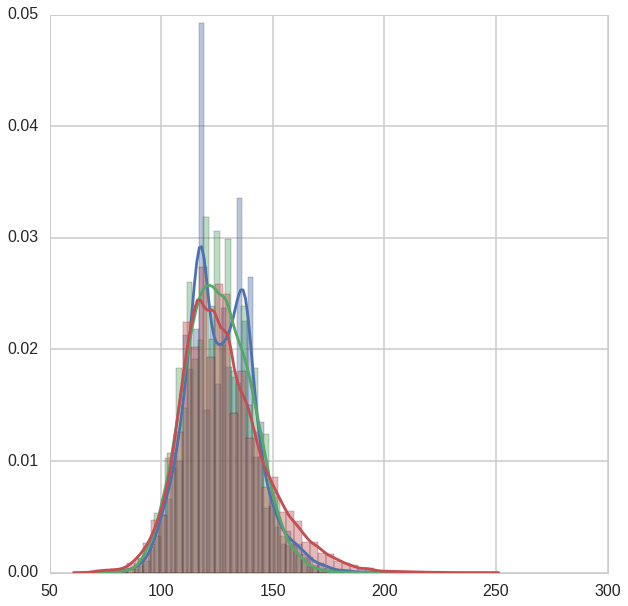

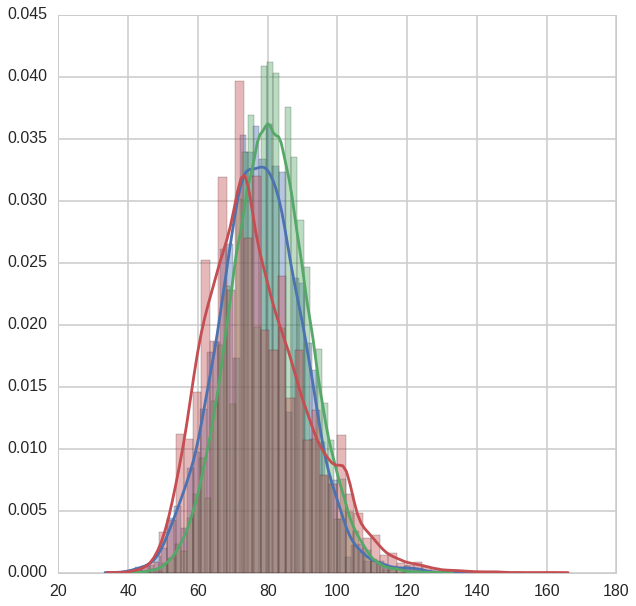

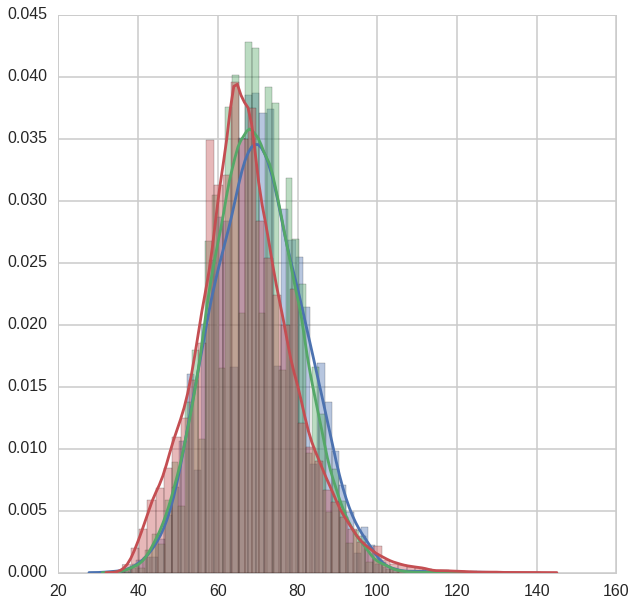

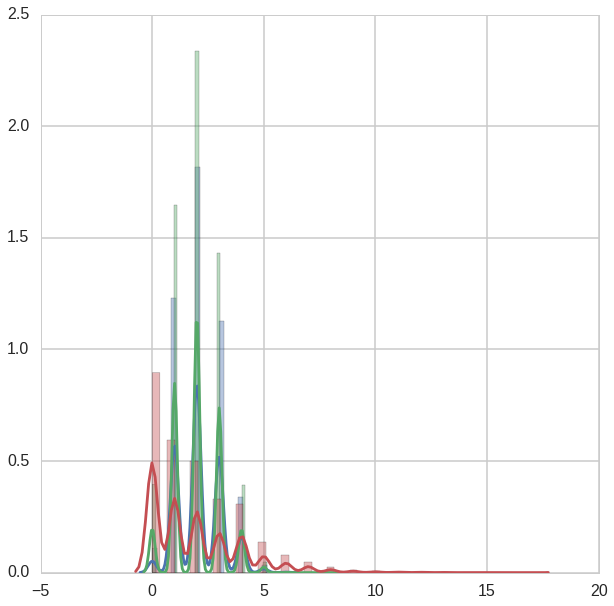

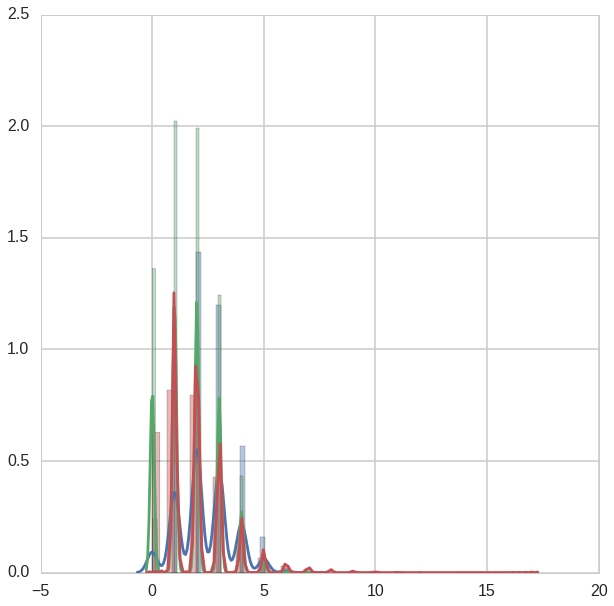

In [11]:
plt.figure(figsize=(10, 10))
ax = sns.distplot(pd.DataFrame(X_train[:, 0, 0]))
ax = sns.distplot(pd.DataFrame(X_public[:, 0, 0]))
ax = sns.distplot(pd.DataFrame(X_private[:, 0, 0]))

plt.figure(figsize=(10, 10))
ax = sns.distplot(pd.DataFrame(X_train[:, 0, 11]))
ax = sns.distplot(pd.DataFrame(X_public[:, 0, 11]))
ax = sns.distplot(pd.DataFrame(X_private[:, 0, 11]))

plt.figure(figsize=(10, 10))
ax = sns.distplot(pd.DataFrame(X_train[:, 1, 0]))
ax = sns.distplot(pd.DataFrame(X_public[:, 1, 0]))
ax = sns.distplot(pd.DataFrame(X_private[:, 1, 0]))

plt.figure(figsize=(10, 10))
ax = sns.distplot(pd.DataFrame(X_train[:, 1, 11]))
ax = sns.distplot(pd.DataFrame(X_public[:, 1, 11]))
ax = sns.distplot(pd.DataFrame(X_private[:, 1, 11]))

plt.figure(figsize=(10, 10))
ax = sns.distplot(pd.DataFrame(X_train[:, 2, 0]))
ax = sns.distplot(pd.DataFrame(X_public[:, 2, 0]))
ax = sns.distplot(pd.DataFrame(X_private[:, 2, 0]))

plt.figure(figsize=(10, 10))
ax = sns.distplot(pd.DataFrame(X_train[:, 2, 11]))
ax = sns.distplot(pd.DataFrame(X_public[:, 2, 11]))
ax = sns.distplot(pd.DataFrame(X_private[:, 2, 11]))

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model
from sklearn.svm import SVC
from sklearn import neighbors

from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

# add neural network

scores = {'real_rf':[], 'public_rf':[], 'private_rf':[],
          'real_linear':[], 'public_linear':[], 'private_linear':[], 
          'real_svm': [], 'public_svm': [], 'private_svm': [],
          'real_nn': [], 'public_nn': [], 'private_nn': []}
full_scores = {}

X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_real = X_real.reshape(X_real.shape[0], -1)
X_public = X_public.reshape(X_public.shape[0], -1)
X_private = X_private.reshape(X_private.shape[0], -1)

print(X_train.shape, X_test.shape, X_real.shape, X_public.shape, X_private.shape)
print(y_train.shape, y_test.shape)

rf_clf = RandomForestClassifier(random_state=0)
nn_clf = neighbors.KNeighborsClassifier()
svm_clf = SVC(C=1.0, kernel='linear', random_state=0)
lr_clf = linear_model.LogisticRegression(random_state=0)

full_real_rf_clf = RandomForestClassifier(random_state=0)
full_real_nn_clf = neighbors.KNeighborsClassifier()
full_real_svm_clf = SVC(C=1.0, kernel='linear', random_state=0)
full_real_lr_clf = linear_model.LogisticRegression(random_state=0)

full_public_rf_clf = RandomForestClassifier(random_state=0)
full_public_nn_clf = neighbors.KNeighborsClassifier()
full_public_svm_clf = SVC(C=1.0, kernel='linear', random_state=0)
full_public_lr_clf = linear_model.LogisticRegression(random_state=0)

full_private_rf_clf = RandomForestClassifier(random_state=0)
full_private_nn_clf = neighbors.KNeighborsClassifier()
full_private_svm_clf = SVC(C=1.0, kernel='linear', random_state=0)
full_private_lr_clf = linear_model.LogisticRegression(random_state=0)

((6000, 36), (502, 36), (6502, 36), (50000, 36), (50000, 36))
((6000,), (502,))


In [13]:
# real_y_pred = full_real_rf_clf.fit(X_train, y_train).predict(X_test)
full_scores['real_rf'] = None #[(accuracy_score(y_test, real_y_pred))]

public_y_pred = full_public_rf_clf.fit(X_public, y_public).predict(X_test)
full_scores['public_rf'] = [(accuracy_score(y_test, public_y_pred))]

private_y_pred = full_private_rf_clf.fit(X_private, y_private).predict(X_test)
full_scores['private_rf'] = [(accuracy_score(y_test, private_y_pred))]

# Nearest Neighbors
#real_y_pred = full_real_nn_clf.fit(X_train, y_train).predict(X_test)
full_scores['real_nn'] = None # [(accuracy_score(y_test, real_y_pred))]

public_y_pred = full_public_nn_clf.fit(X_public, y_public).predict(X_test)
full_scores['public_nn'] = [(accuracy_score(y_test, public_y_pred))]

private_y_pred = nn_clf.fit(X_private, y_private).predict(X_test)
full_scores['private_nn'] = [(accuracy_score(y_test, private_y_pred))]

# SVM
real_y_pred = full_real_svm_clf.fit(X_train, y_train).predict(X_test)
full_scores['real_svm'] = None #[(accuracy_score(y_test, real_y_pred))]

public_y_pred = full_public_svm_clf.fit(X_public, y_public).predict(X_test)
full_scores['public_svm'] = [(accuracy_score(y_test, public_y_pred))]

private_y_pred = full_private_svm_clf.fit(X_private, y_private).predict(X_test)
full_scores['private_svm'] = [(accuracy_score(y_test, private_y_pred))]

# Logistic Regression
real_y_pred = full_real_lr_clf.fit(X_train, y_train).predict(X_test)
full_scores['real_linear'] = None #[(accuracy_score(y_test, real_y_pred))]

public_y_pred = full_public_lr_clf.fit(X_public, y_public).predict(X_test)
full_scores['public_linear'] = [(accuracy_score(y_test, public_y_pred))]

private_y_pred = full_private_lr_clf.fit(X_private, y_private).predict(X_test)
full_scores['private_linear'] = [(accuracy_score(y_test, private_y_pred))]
print(full_scores)

{'real_rf': None, 'private_nn': [0.85657370517928288], 'public_linear': [0.89043824701195218], 'public_rf': [0.9083665338645418], 'public_nn': [0.8605577689243028], 'real_nn': None, 'public_svm': [0.91235059760956172], 'private_linear': [0.8366533864541833], 'private_rf': [0.84262948207171318], 'real_svm': None, 'private_svm': [0.8844621513944223], 'real_linear': None}


In [14]:
for i in range(10):
    print(i)
    start = i * generate_count
    stop = (i+1) * generate_count
    
    # Random forest
    real_y_pred = rf_clf.fit(X_train, y_train).predict(X_test)
    scores['real_rf'].append(accuracy_score(y_test, real_y_pred))

    public_y_pred = rf_clf.fit(X_public[start:stop], y_public[start:stop]).predict(X_test)
    scores['public_rf'].append(accuracy_score(y_test, public_y_pred))

    private_y_pred = rf_clf.fit(X_private[start:stop], y_private[start:stop]).predict(X_test)
    scores['private_rf'].append(accuracy_score(y_test, private_y_pred))

    # Nearest Neighbors
    real_y_pred = nn_clf.fit(X_train, y_train).predict(X_test)
    scores['real_nn'].append(accuracy_score(y_test, real_y_pred))

    public_y_pred = nn_clf.fit(X_public[start:stop], y_public[start:stop]).predict(X_test)
    scores['public_nn'].append(accuracy_score(y_test, public_y_pred))

    private_y_pred = nn_clf.fit(X_private[start:stop], y_private[start:stop]).predict(X_test)
    scores['private_nn'].append(accuracy_score(y_test, private_y_pred))

    # SVM
    real_y_pred = svm_clf.fit(X_train, y_train).predict(X_test)
    scores['real_svm'].append(accuracy_score(y_test, real_y_pred))

    public_y_pred = svm_clf.fit(X_public[start:stop], y_public[start:stop]).predict(X_test)
    scores['public_svm'].append(accuracy_score(y_test, public_y_pred))

    private_y_pred = svm_clf.fit(X_private[start:stop], y_private[start:stop]).predict(X_test)
    scores['private_svm'].append(accuracy_score(y_test, private_y_pred))

    # Logistic Regression
    real_y_pred = lr_clf.fit(X_train, y_train).predict(X_test)
    scores['real_linear'].append(accuracy_score(y_test, real_y_pred))

    public_y_pred = lr_clf.fit(X_public[start:stop], y_public[start:stop]).predict(X_test)
    scores['public_linear'].append(accuracy_score(y_test, public_y_pred))

    private_y_pred = lr_clf.fit(X_private[start:stop], y_private[start:stop]).predict(X_test)
    scores['private_linear'].append(accuracy_score(y_test, private_y_pred))
        
print(scores)

0
1
2
3
4
5
6
7
8
9
{'real_rf': [0.92629482071713143, 0.92629482071713143, 0.92629482071713143, 0.92629482071713143, 0.92629482071713143, 0.92629482071713143, 0.92629482071713143, 0.92629482071713143, 0.92629482071713143, 0.92629482071713143], 'private_nn': [0.81872509960159368, 0.85059760956175301, 0.85458167330677293, 0.85458167330677293, 0.78286852589641431, 0.78087649402390436, 0.80677290836653381, 0.77290836653386452, 0.82071713147410363, 0.87051792828685259], 'public_linear': [0.82470119521912355, 0.8027888446215139, 0.73505976095617531, 0.82470119521912355, 0.8027888446215139, 0.83466135458167334, 0.82868525896414347, 0.84860557768924305, 0.83067729083665343, 0.84462151394422313], 'public_rf': [0.89442231075697209, 0.89442231075697209, 0.90239043824701193, 0.9083665338645418, 0.91035856573705176, 0.88844621513944222, 0.8844621513944223, 0.89641434262948205, 0.88247011952191234, 0.89243027888446214], 'public_nn': [0.87450199203187251, 0.83067729083665343, 0.84860557768924305, 0.8

In [15]:
colors = ['#B21E0D', '#FF412B', '#0E5FCC', '#537CB2', '#9300B2', '#DA2BFF']
visit_codes = ['RZ', '1', '2', '3', '6', '9', '12', '15', '18', '21', '24', '27',
               'RZ', '1', '2', '3', '6', '9', '12', '15', '18', '21', '24', '27',
               'RZ', '1', '2', '3', '6', '9', '12', '15', '18', '21', '24', '27']

importances = {'method': [], 'variable': [], 'importance': []}

real_rf_importances = full_real_rf_clf.feature_importances_
public_rf_importances = full_public_rf_clf.feature_importances_
private_rf_importances = full_private_rf_clf.feature_importances_

for i in range(len(real_rf_importances)):
    importances['method'].append('Real')
    importances['variable'].append(i)
    importances['importance'].append(real_rf_importances[i])
    importances['method'].append('Non-Private')
    importances['variable'].append(i)
    importances['importance'].append(public_rf_importances[i])
    importances['method'].append('Private')
    importances['variable'].append(i)
    importances['importance'].append(private_rf_importances[i])

plt.figure(figsize=(18, 9))
importance_df = pd.DataFrame.from_dict(importances)
ax = sns.stripplot(x="variable", y="importance", hue="method",
                   data=importance_df, palette=[colors[0], colors[2], colors[4]], size=12)
plt.title("Random Forest Feature Importances")
ax.set_xticklabels(visit_codes, fontsize=18)
plt.ylabel('Importance Score', fontsize=18)
plt.xlabel('Systolic Blood Pressure (visit month)       Diastolic Blood Pressure (visit month)          Medication Count (visit month)     ',
           fontsize=18)
plt.legend(loc='upper left', fontsize=20)
plt.show()

coefs = {'method': [], 'variable': [], 'importance': []}
real_svm_coefs = full_real_svm_clf.coef_[0]
public_svm_coefs = full_public_svm_clf.coef_[0]
private_svm_coefs = full_private_svm_clf.coef_[0]

for i in range(len(real_svm_coefs)):
    coefs['method'].append('Real')
    coefs['variable'].append(i)
    coefs['importance'].append(real_svm_coefs[i])
    coefs['method'].append('Non-Private')
    coefs['variable'].append(i)
    coefs['importance'].append(public_svm_coefs[i])
    coefs['method'].append('Private')
    coefs['variable'].append(i)
    coefs['importance'].append(private_svm_coefs[i])
    
plt.figure(figsize=(18, 9))
importance_df = pd.DataFrame.from_dict(coefs)
ax = sns.stripplot(x="variable", y="importance", hue="method",
              data=importance_df, palette=[colors[0], colors[2], colors[4]], size=12)
plt.xlabel('Systolic Blood Pressure (visit month)       Diastolic Blood Pressure (visit month)          Medication Count (visit month)     ',
           fontsize=18)
plt.title("SVM Feature Coefficients")

ax.set_xticklabels(visit_codes)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.legend(loc='upper left', fontsize=20)
plt.show()


coefs = {'method': [], 'variable': [], 'importance': []}
real_lr_coefs = full_real_lr_clf.coef_[0]
public_lr_coefs = full_public_lr_clf.coef_[0]
private_lr_coefs = full_private_lr_clf.coef_[0]

for i in range(len(real_svm_coefs)):
    coefs['method'].append('Real')
    coefs['variable'].append(i)
    coefs['importance'].append(real_lr_coefs[i])
    coefs['method'].append('Non-Private')
    coefs['variable'].append(i)
    coefs['importance'].append(public_lr_coefs[i])
    coefs['method'].append('Private')
    coefs['variable'].append(i)
    coefs['importance'].append(private_lr_coefs[i])
    
plt.figure(figsize=(18, 9))
importance_df = pd.DataFrame.from_dict(coefs)
ax = sns.stripplot(x="variable", y="importance", hue="method",
              data=importance_df, palette=[colors[0], colors[2], colors[4]], size=12)
plt.xlabel('Systolic Blood Pressure (visit month)       Diastolic Blood Pressure (visit month)          Medication Count (visit month)     ',
           fontsize=18)
plt.title("Logistic Regression Feature Coefficients")

ax.set_xticklabels(visit_codes)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.legend(loc='upper left', fontsize=20)
plt.show()

NotFittedError: Estimator not fitted, call `fit` before `feature_importances_`.

In [ ]:
from scipy.stats import spearmanr
from scipy.stats import pearsonr

# rf_real_list = real_rf_importances.argsort().argsort()
# rf_public_list = public_rf_importances.argsort().argsort()
# rf_private_list = private_rf_importances.argsort().argsort()

# print(real_rf_importances, public_rf_importances, private_rf_importances)
# print(rf_real_list, rf_public_list, rf_private_list)

print('RF')
print(spearmanr(real_rf_importances, public_rf_importances))
print(spearmanr(real_rf_importances, private_rf_importances))
print(spearmanr(public_rf_importances, private_rf_importances))

# print('List')
# print(spearmanr(rf_real_list, rf_public_list))
# print(spearmanr(rf_real_list, rf_private_list))
# print(spearmanr(rf_public_list, rf_private_list))

print('SVM')
print(spearmanr(real_svm_coefs, public_svm_coefs))
print(spearmanr(real_svm_coefs, private_svm_coefs))
print(spearmanr(public_svm_coefs, private_svm_coefs))

print('LR')
print(spearmanr(real_lr_coefs, public_lr_coefs))
print(spearmanr(real_lr_coefs, private_lr_coefs))
print(spearmanr(public_lr_coefs, private_lr_coefs))


In [ ]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'axes.labelsize': 40,
          'axes.titlesize':'x-large',
          'xtick.labelsize':15,
          'ytick.labelsize':15}
pylab.rcParams.update(params)

plt.figure(figsize=(20, 20))
plt.ylabel('Test Accuracy')
plt.xlabel('Training Data')
scores['real_rf'][5] = None
scores['real_linear'][5] = None
scores['real_nn'][5] = None
scores['real_svm'][5] = None
transfer_scores = pd.DataFrame.from_dict(scores)
full_scores = pd.DataFrame.from_dict(full_scores)
cat_list = ["Real", "Non-Private", "Private"]
order = ['real_rf', 'public_rf', 'private_rf', 'real_linear',
         'public_linear', 'private_linear', 'real_svm', 'public_svm',
         'private_svm', 'real_nn', 'public_nn', 'private_nn']
# ax = sns.boxplot(data=transfer_scores, order=order) #, order=cat_list)

plot_scores = pd.concat([transfer_scores[:1], transfer_scores[5:6], full_scores])
      #real_nn   real_rf  real_svm])
plot_scores.index = [0, 1, 2]
print(plot_scores)

ax = sns.swarmplot(data=plot_scores, order=order, size=30)
ax.set_xticklabels(['Real \nRandom \nForest', 'Non-Private \nRandom \nForest', 'Private \nRandom \nForest',
                    'Real \nLR', 'Non-Private \nLR', 'Private \nLR', 
                    'Real \nSVM', 'Non-Private \nSVM', 'Private \nSVM',
                    'Real \nNearest \nNeighbors', 'Non-Private \nNearest \nNeighbors', 'Private \nNearest \nNeighbors'
                   ], fontsize=16)
ax.set_ylim([0.5,1])

In [ ]:
f, ax = plt.subplots(figsize=(11, 9))

d = pd.DataFrame(X_train)
corr = d.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
plt.xlabel('Systolic Blood Pressure   Diastolic Blood Pressure      Medication Count    ',
           fontsize=14)
plt.ylabel('Medication Count       Diastolic Blood Pressure       Systolic Blood Pressure   ',
           fontsize=14)

f, ax = plt.subplots(figsize=(11, 9))
d = pd.DataFrame(X_public)
corr = d.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
plt.xlabel('Systolic Blood Pressure   Diastolic Blood Pressure      Medication Count    ',
           fontsize=14)
plt.ylabel('Medication Count       Diastolic Blood Pressure       Systolic Blood Pressure   ',
           fontsize=14)

f, ax = plt.subplots(figsize=(11, 9))
d = pd.DataFrame(X_private)
corr = d.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
plt.xlabel('Systolic Blood Pressure   Diastolic Blood Pressure      Medication Count    ',
           fontsize=14)
plt.ylabel('Medication Count       Diastolic Blood Pressure       Systolic Blood Pressure   ',
           fontsize=14)

In [ ]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 30,
          'axes.labelsize': 15,
          'axes.titlesize': 40,
          'xtick.labelsize':10,
          'ytick.labelsize':10}
pylab.rcParams.update(params)

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

plt.figure(figsize=(12, 12))
X_pca = np.concatenate((X_train[:3000], X_train[3000:]))
print(X_pca.shape)

y = np.array([1] * 3000 + [0] * 3000)
pca = PCA(n_components=2)
X_r = pca.fit(X_pca).transform(X_pca)

target_names = ['Real', 'Real']
colors = ['navy', 'darkorange']
lw = 2

print(X_r.shape)
print(len(target_names))
for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)

plt.title('PCA of Real vs. Real')

print(pca.explained_variance_ratio_)

plt.figure(figsize=(12, 12))
X_pca = np.concatenate((X_train, X_public))
print(X_pca.shape)

y = np.array([1] * 6000 + [0] * 6000)
pca = PCA(n_components=2)
X_r = pca.fit(X_pca).transform(X_pca)

target_names = ['Real', 'Fake']
colors = ['navy', 'darkorange']
lw = 2

for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)

plt.title('PCA of Real vs. Public Fake')

print(pca.explained_variance_ratio_)

plt.figure(figsize=(12, 12))
X_pca = np.concatenate((X_train, X_private))
print(X_pca.shape)

y = np.array([1] * 6000 + [0] * generate_count)
pca = PCA(n_components=2)
X_r = pca.fit(X_pca).transform(X_pca)

target_names = ['Real', 'Fake']
colors = ['navy', 'darkorange']
lw = 2

for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)

plt.title('PCA of Real vs. Private Fake')

print(pca.explained_variance_ratio_)